In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# load BERT base
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained(
    "bert-base-uncased",
    attn_implementation="eager",
    output_attentions=True
)
# DON'T CHANGE ANYTHING IN THIS CELL

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Implements scaled-dot-product attention.
    Shapes:
        Q, K, V : (B, H, L, d_k)   # B=batch, H=heads, L=sequence
        mask    : broadcastable to (B, H, L, L)   (0 = pad, 1 = keep)
    Returns:
        out  : (B, H, L, d_k)
        attn : (B, H, L, L)
    """

    # ### TODO 1. raw scores = Q * Kᵀ (hint: transpose(-2, -1))
    scores = Q @ K.transpose(-2, -1) # Matrix multiplication between Q and K, which is a dot product between the query and key vectors.

    # ### TODO 2. scale by √d_k
    d_k = Q.size(-1)
    scores = scores / (d_k ** 0.5) # Scale the scores by the square root of the dimension of the key vectors.

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # ### TODO 3. softmax over keys dimension (-1)
    attn = F.softmax(scores, dim=-1) # Apply softmax to the scores to get the attention weights.

    # ### TODO 4. multiply by V
    out = attn @ V # Multiply the attention weights by the value vectors to get the final output.

    return out, attn


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=768, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must split evenly"
        self.h   = num_heads
        self.d_k = d_model // num_heads

        # Define the query, key, value, and output linear layers.
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        B, L, C = x.shape

        # ### TODO 1-3. project & reshape for heads
        Q = self.W_q(x).view(B, L, self.h, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, L, self.h, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, L, self.h, self.d_k).transpose(1, 2)

        # ### TODO 4. call single-head attention
        out, attn =scaled_dot_product_attention(Q, K, V, mask)

        # ### TODO 5-6. merge heads & final linear
        out = out.transpose(1, 2).contiguous().view(B, L, C)
        out = self.W_o(out) # Apply the output linear layer to the concatenated output of all heads.

        return out, attn


In [5]:
@torch.no_grad()
def embed_sentence(text):
    ids   = tokenizer(text, return_tensors="pt")
    emb   = bert.embeddings(ids["input_ids"])
    mask  = ids["attention_mask"].unsqueeze(1).unsqueeze(2)
    tokens = tokenizer.convert_ids_to_tokens(ids["input_ids"][0])
    return emb, mask, tokens

def plot_heads(attn, tokens, heads_per_row=4):
    """
    attn: (B=1, H, L, L)   attention from our MHA
    """
    attn = attn[0].cpu()
    H, L, _ = attn.shape
    rows = (H + heads_per_row - 1)//heads_per_row
    fig, axes = plt.subplots(rows, heads_per_row, figsize=(4*heads_per_row,4*rows))
    axes = axes.flatten()
    for h in range(H):
        sns.heatmap(attn[h], vmin=0, vmax=attn.max(),
                    cmap="viridis", square=True,
                    xticklabels=tokens, yticklabels=tokens,
                    ax=axes[h], cbar=False)
        axes[h].set_title(f"Head {h}")
        axes[h].tick_params(labelsize=8, rotation=90)
    for ax in axes[H:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    # DON'T CHANGE ANYTHING IN THIS CELL

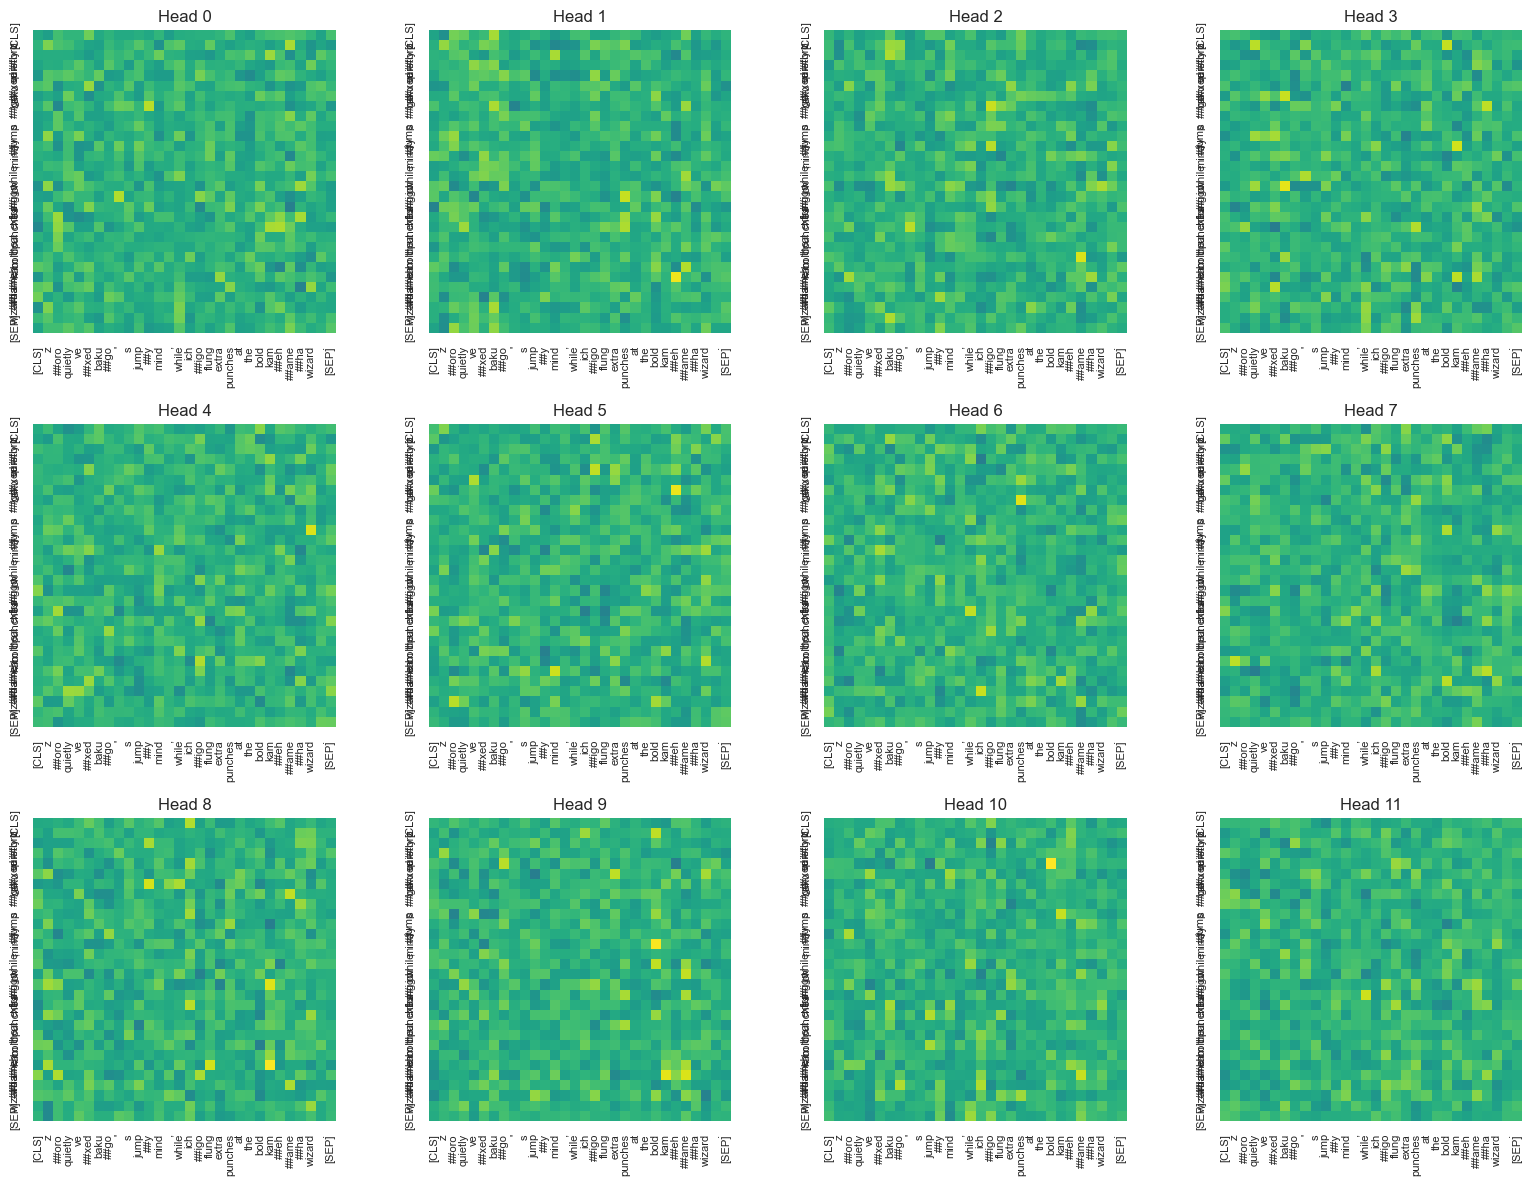

In [6]:
# Check our implementation (it isn't trained so the attention will be all over the place.)

sentence = "Zoro quietly vexed Bakugo's jumpy mind, while Ichigo flung extra punches at the bold Kamehameha wizard." # ### TODO: Use a unique sentence!
x, mask, toks = embed_sentence(sentence)

mha = MultiHeadAttention(d_model=768, num_heads=12)
mha.eval()

with torch.no_grad():
    out, attn = mha(x, mask)

plot_heads(attn, toks)

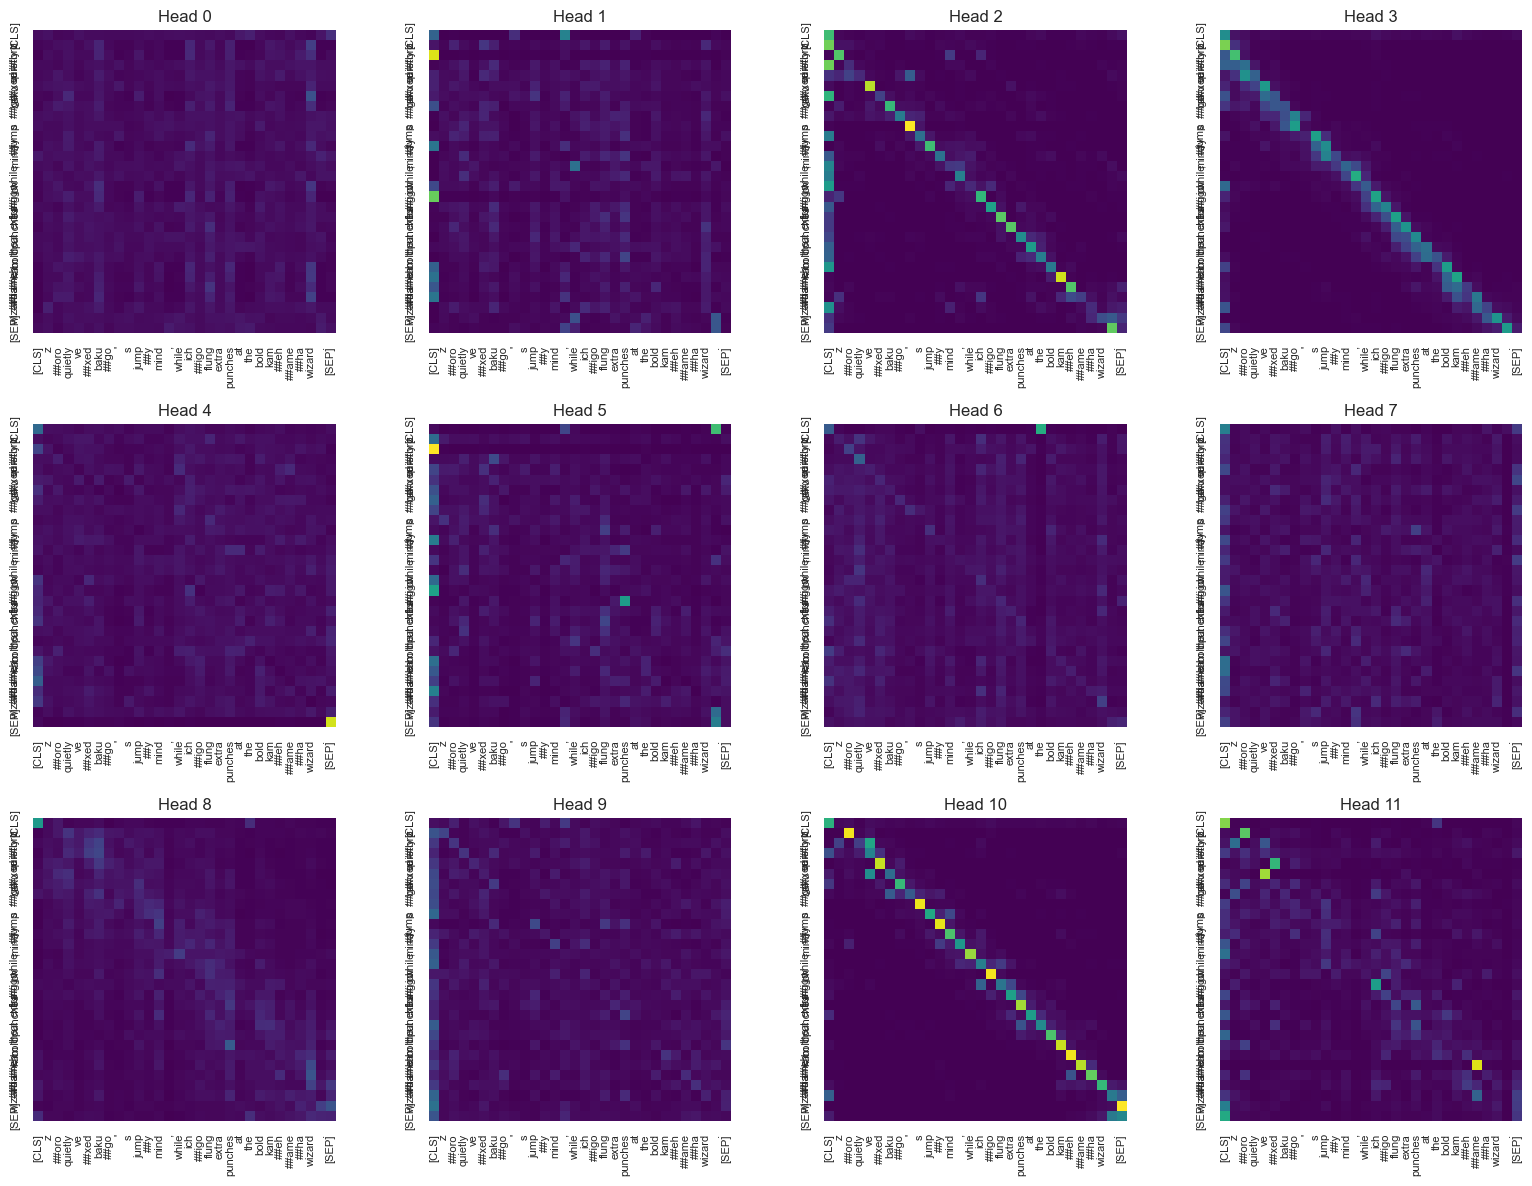

In [7]:
# See attention directly using BERT.

x, mask, toks = embed_sentence(sentence)

with torch.no_grad():
    outputs = bert(**tokenizer(sentence, return_tensors="pt"), output_attentions=True)
    attn = outputs.attentions[0]
plot_heads(attn, toks, heads_per_row=4)

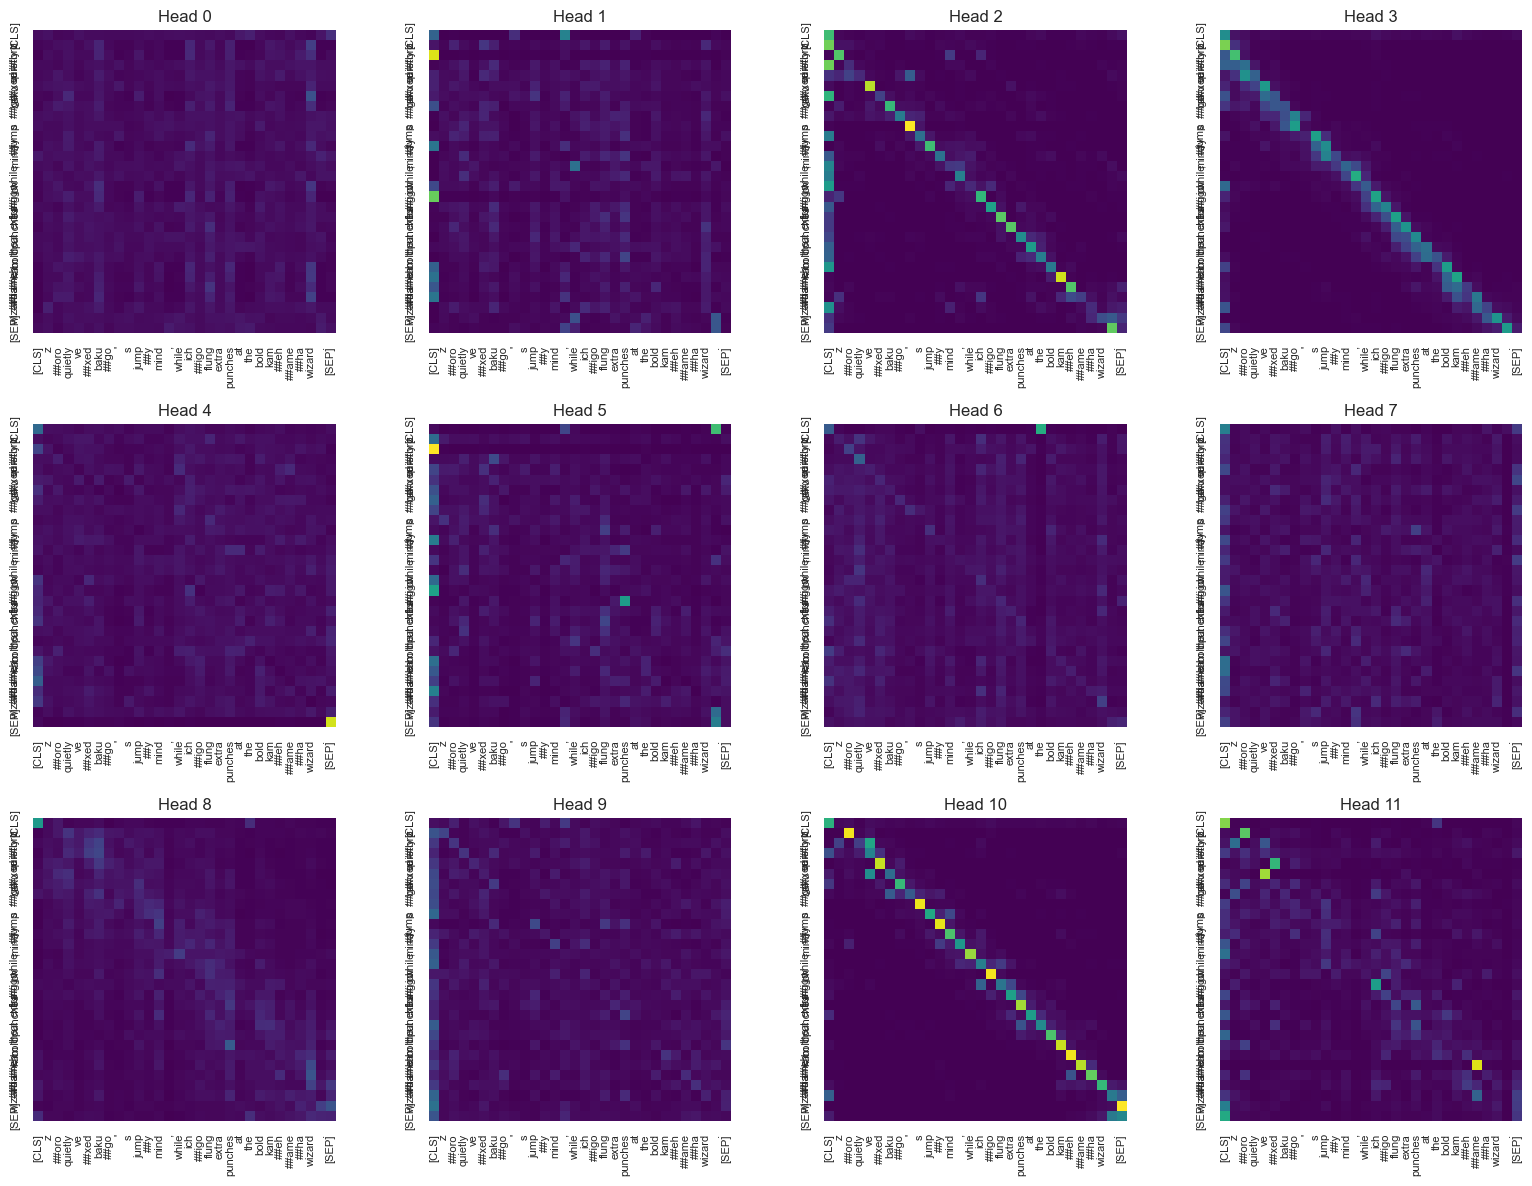

In [8]:
# Use pretrained BERT weights to test our implementation.

bert_sa   = bert.encoder.layer[0].attention.self
bert_dout = bert.encoder.layer[0].attention.output.dense

mha_pt = MultiHeadAttention(d_model=768, num_heads=12)

with torch.no_grad():
    mha_pt.W_q.weight.copy_(bert_sa.query.weight)
    mha_pt.W_q.bias.copy_( bert_sa.query.bias )
    mha_pt.W_k.weight.copy_(bert_sa.key.weight)
    mha_pt.W_k.bias.copy_( bert_sa.key.bias )
    mha_pt.W_v.weight.copy_(bert_sa.value.weight)
    mha_pt.W_v.bias.copy_( bert_sa.value.bias )
    mha_pt.W_o.weight.copy_(bert_dout.weight)
    mha_pt.W_o.bias.copy_( bert_dout.bias )

mha_pt.eval()
with torch.no_grad():
    out_pt, attn_pt = mha_pt(x, mask)
plot_heads(attn_pt, toks)

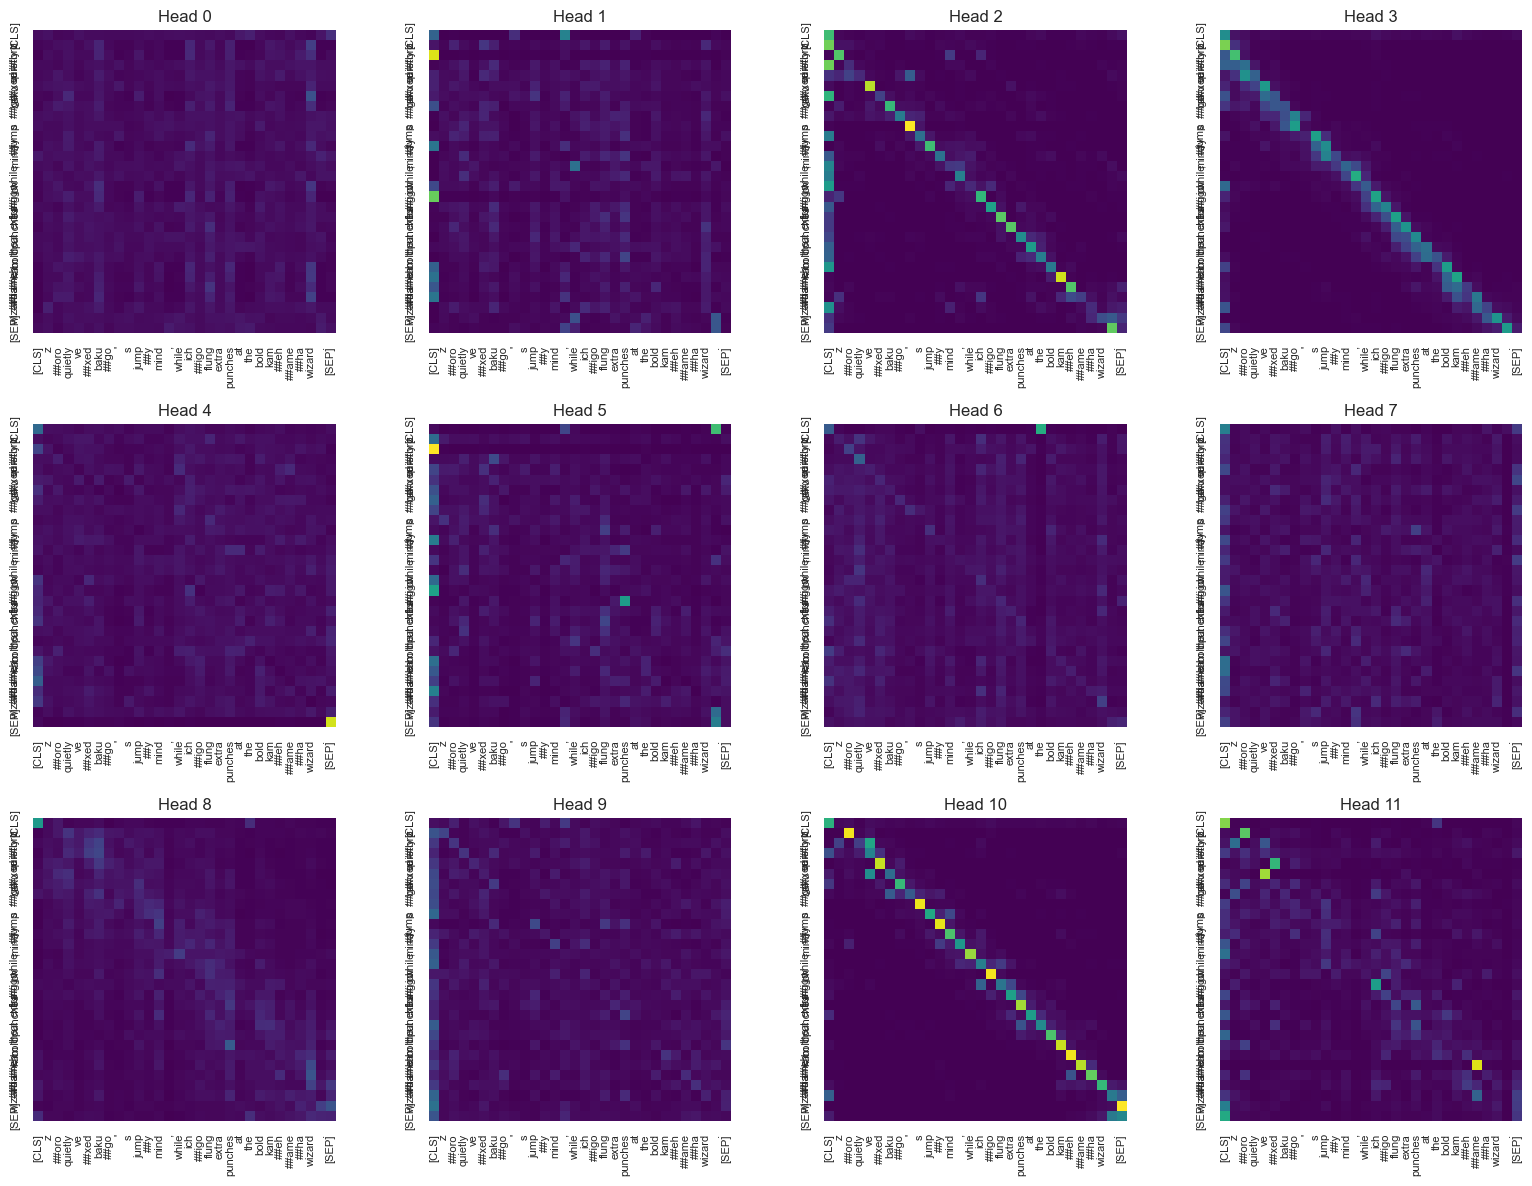

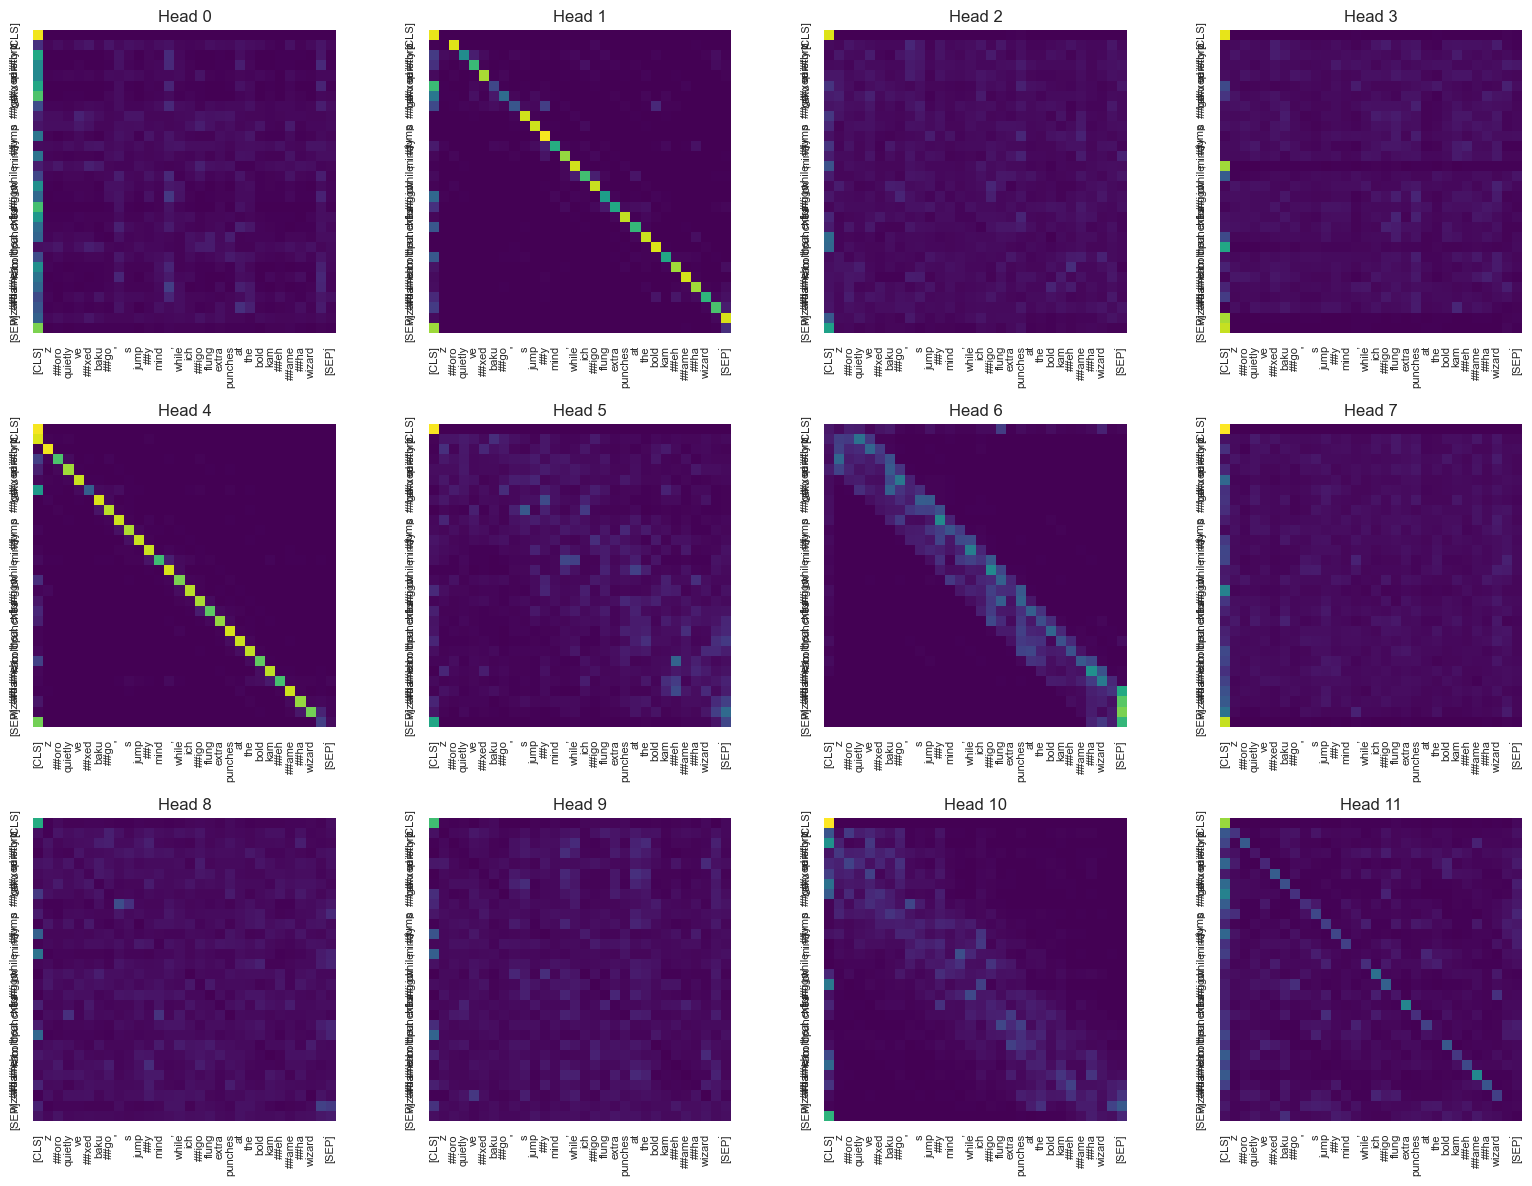

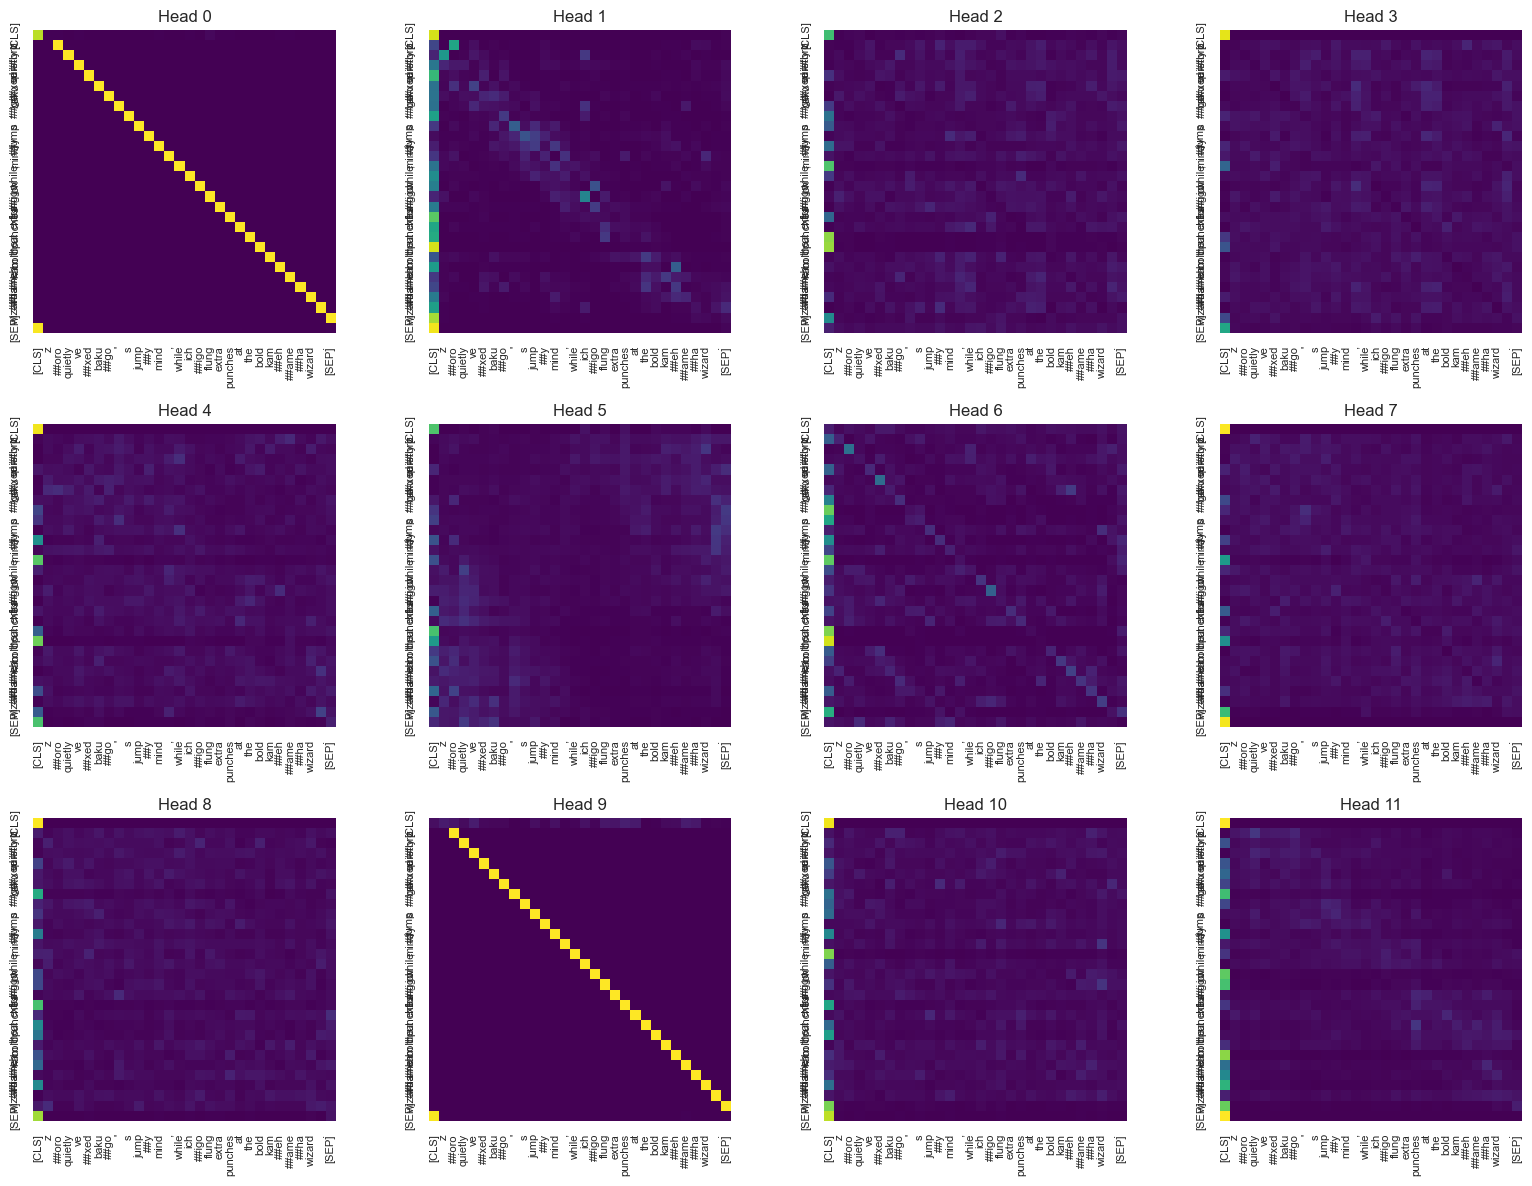

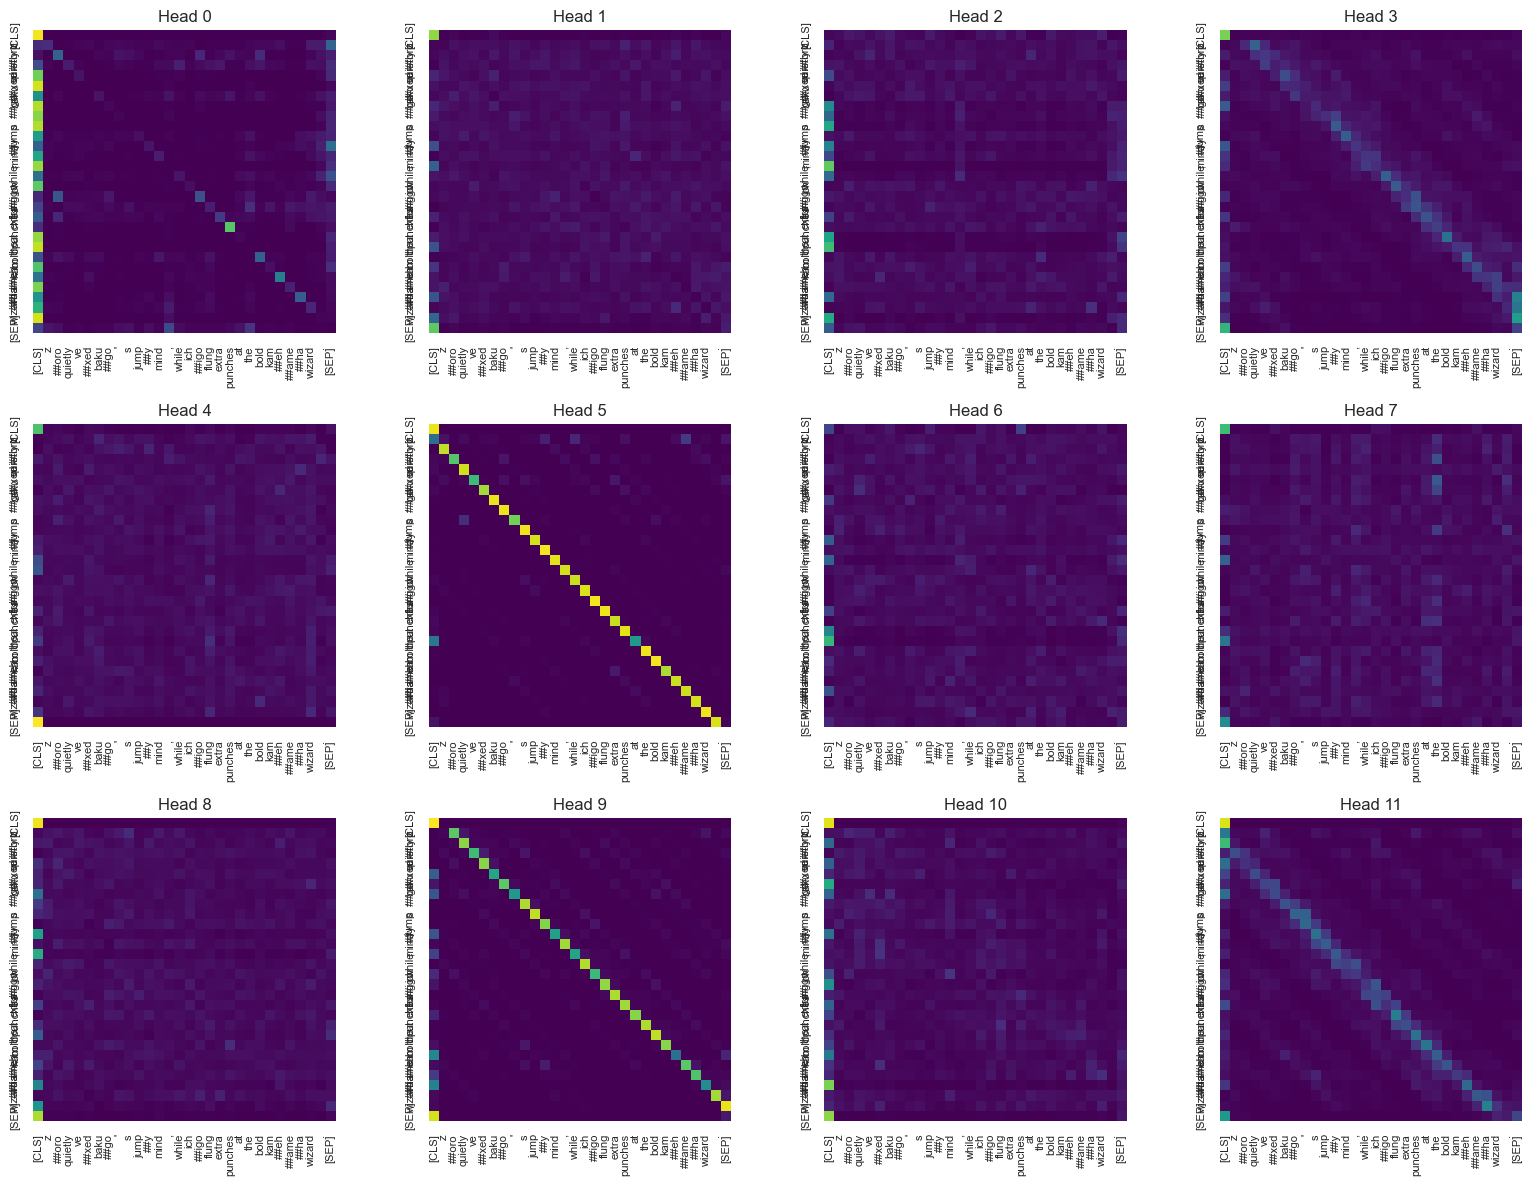

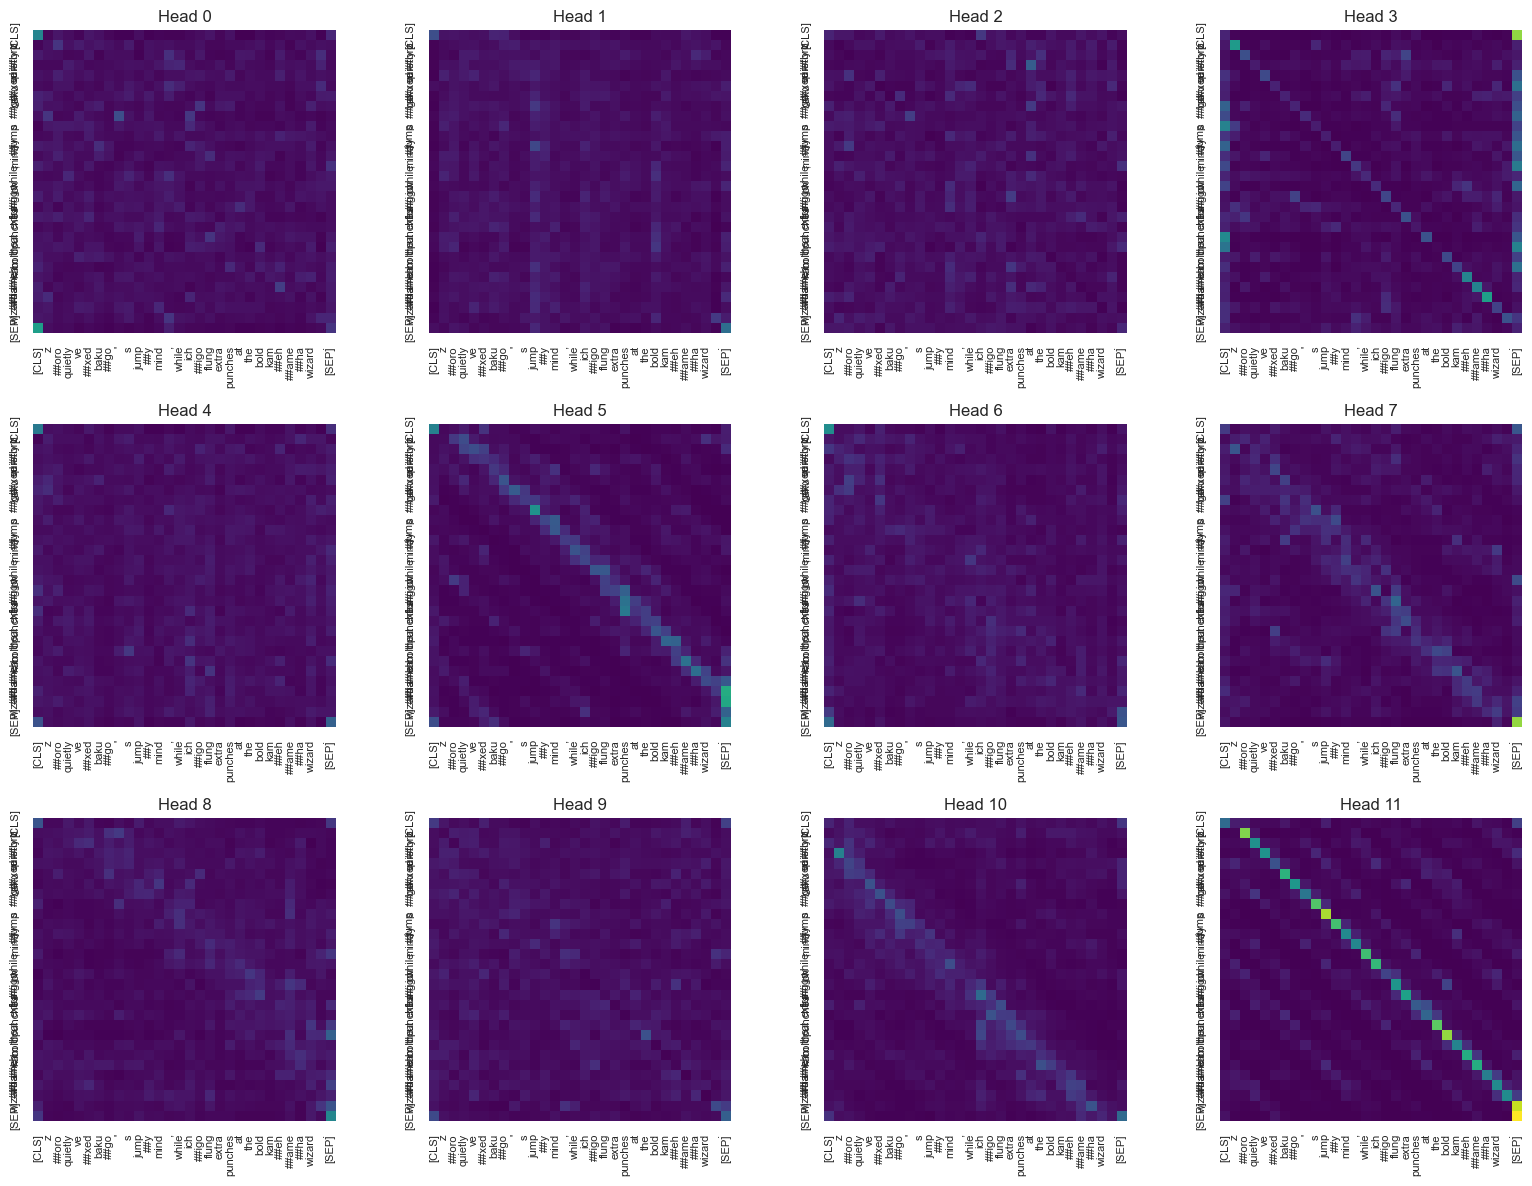

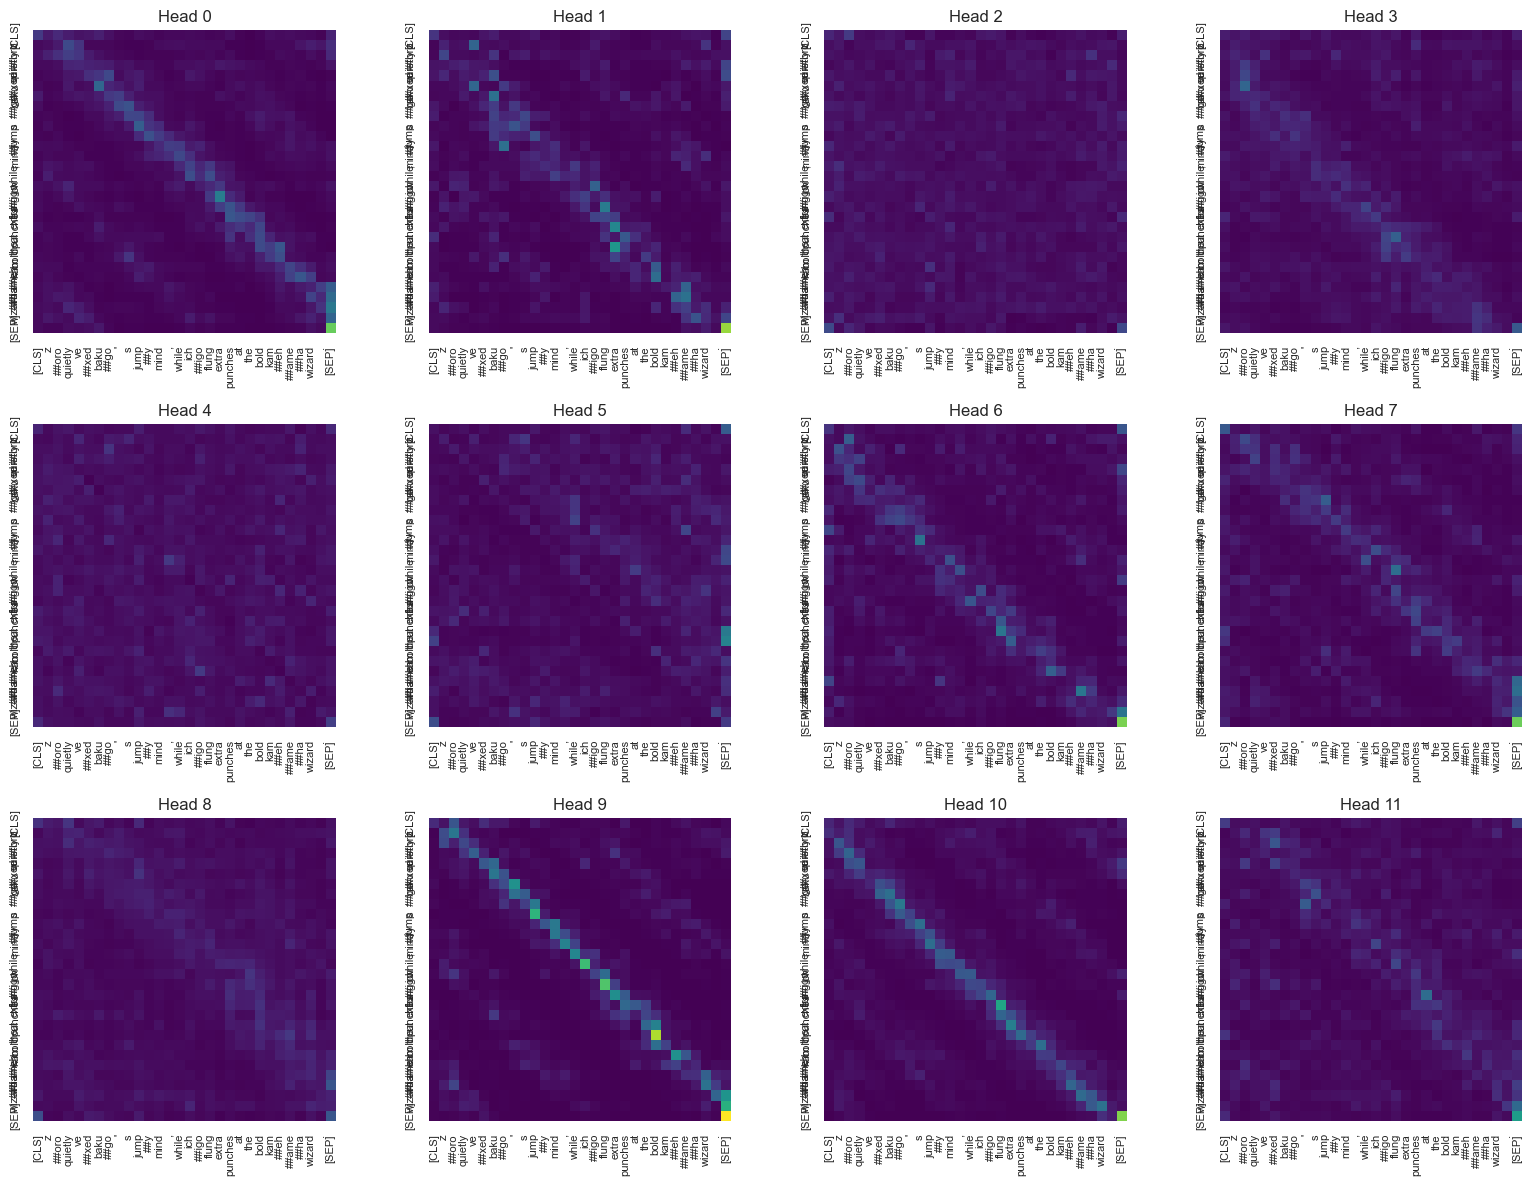

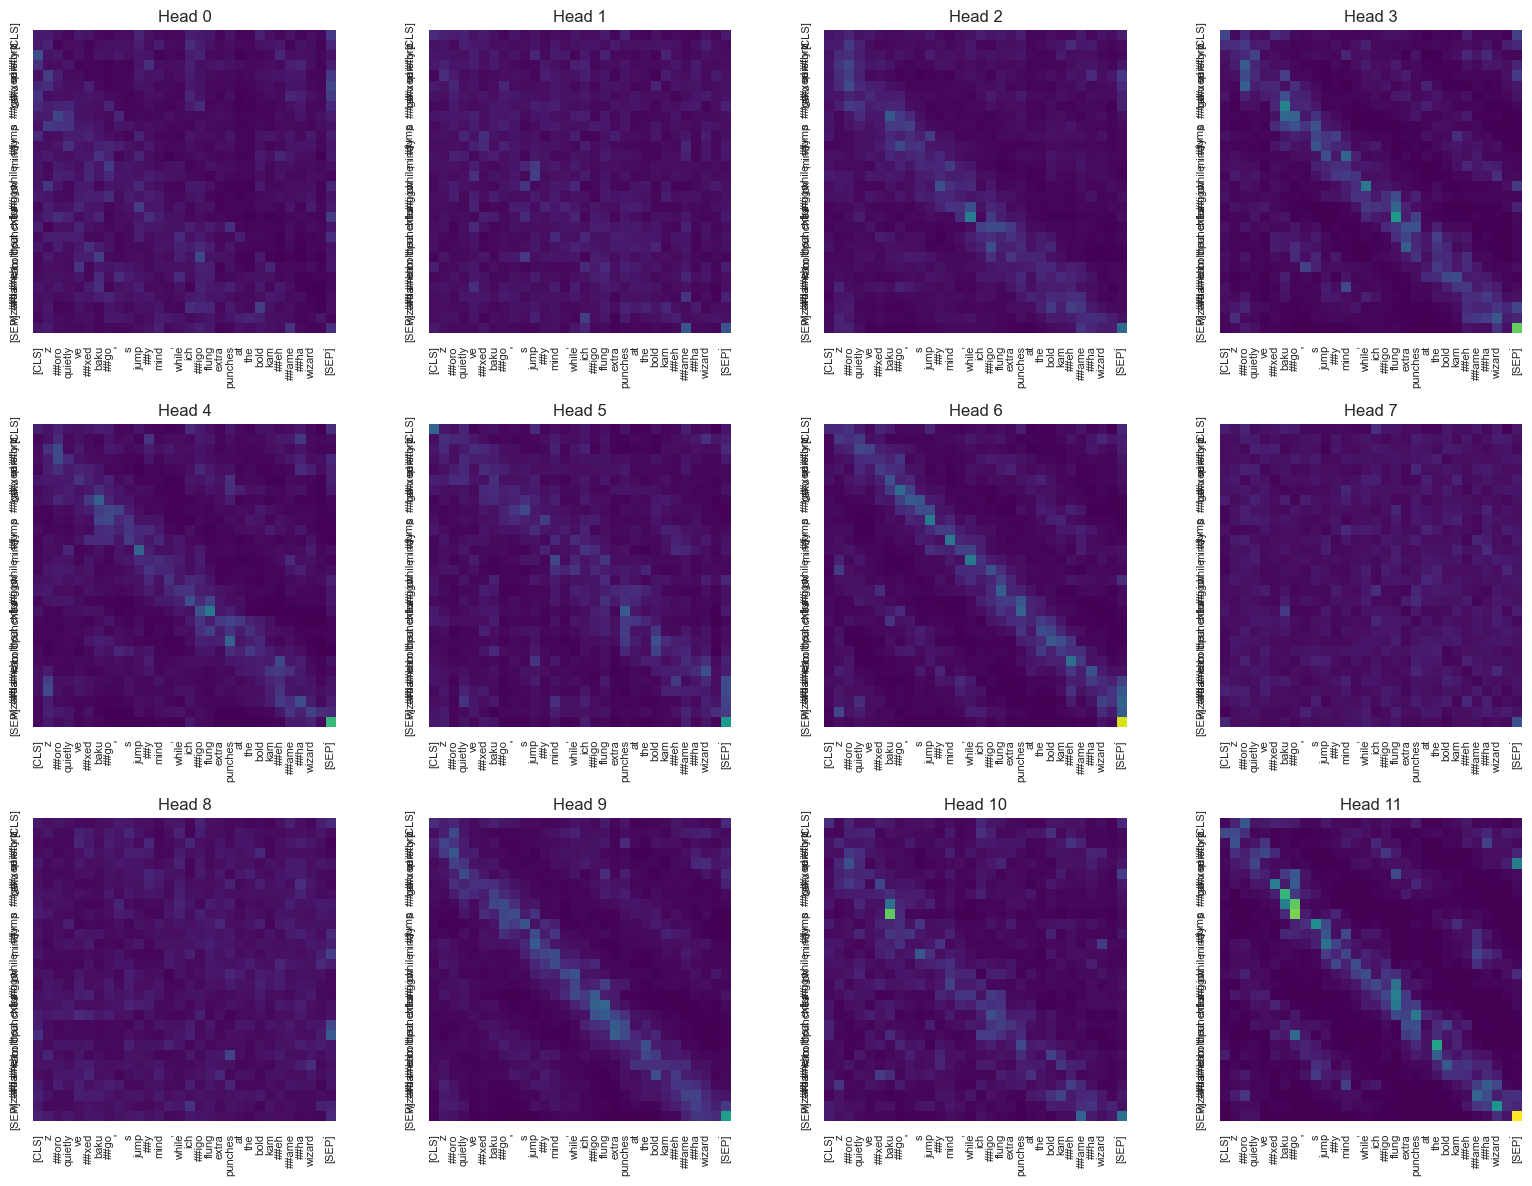

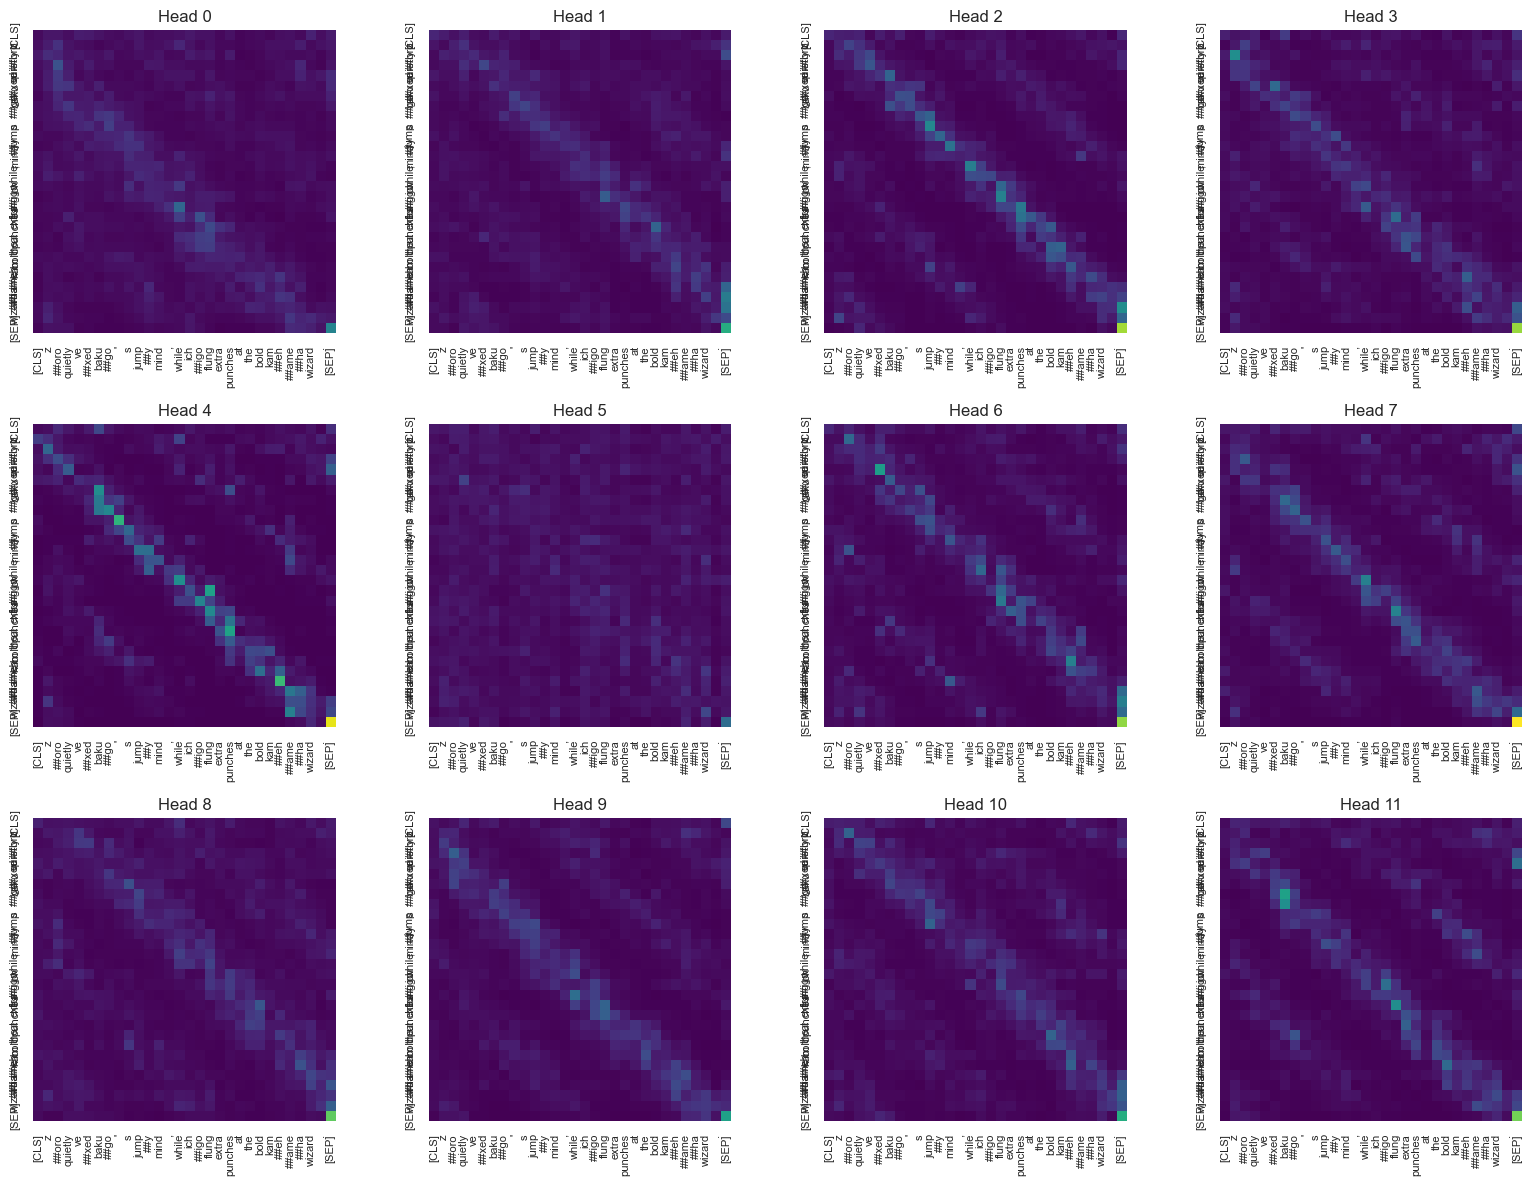

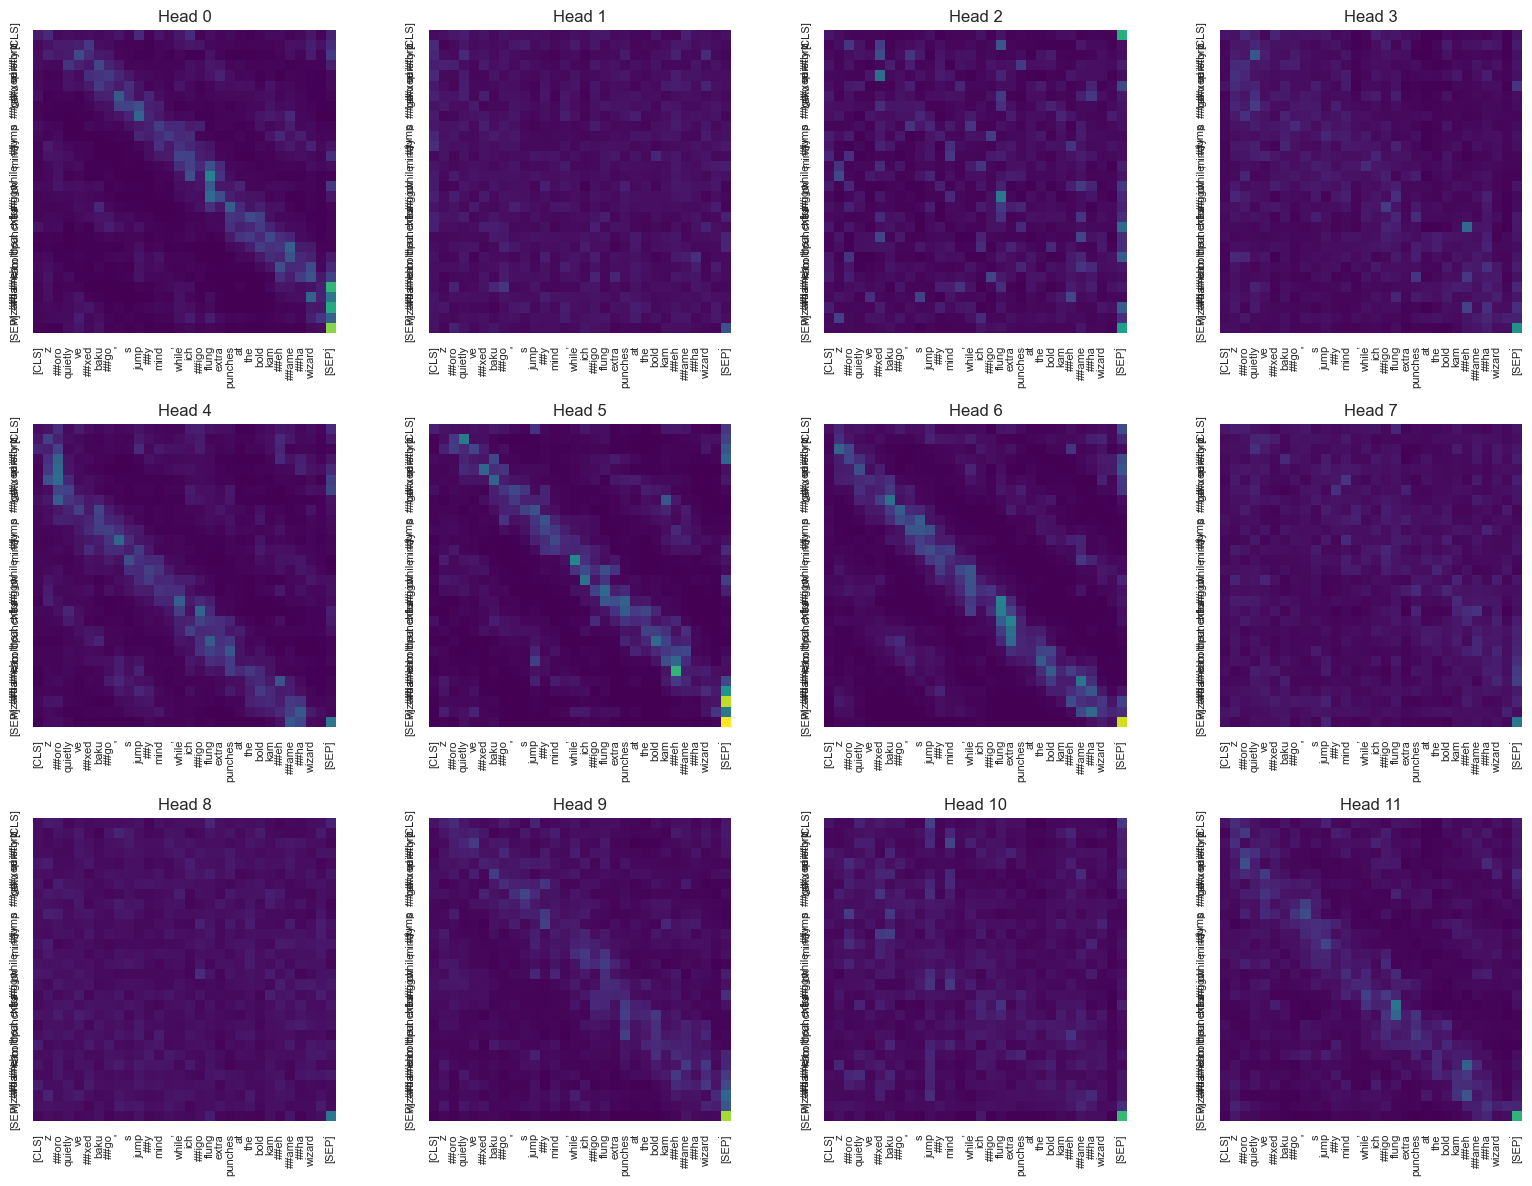

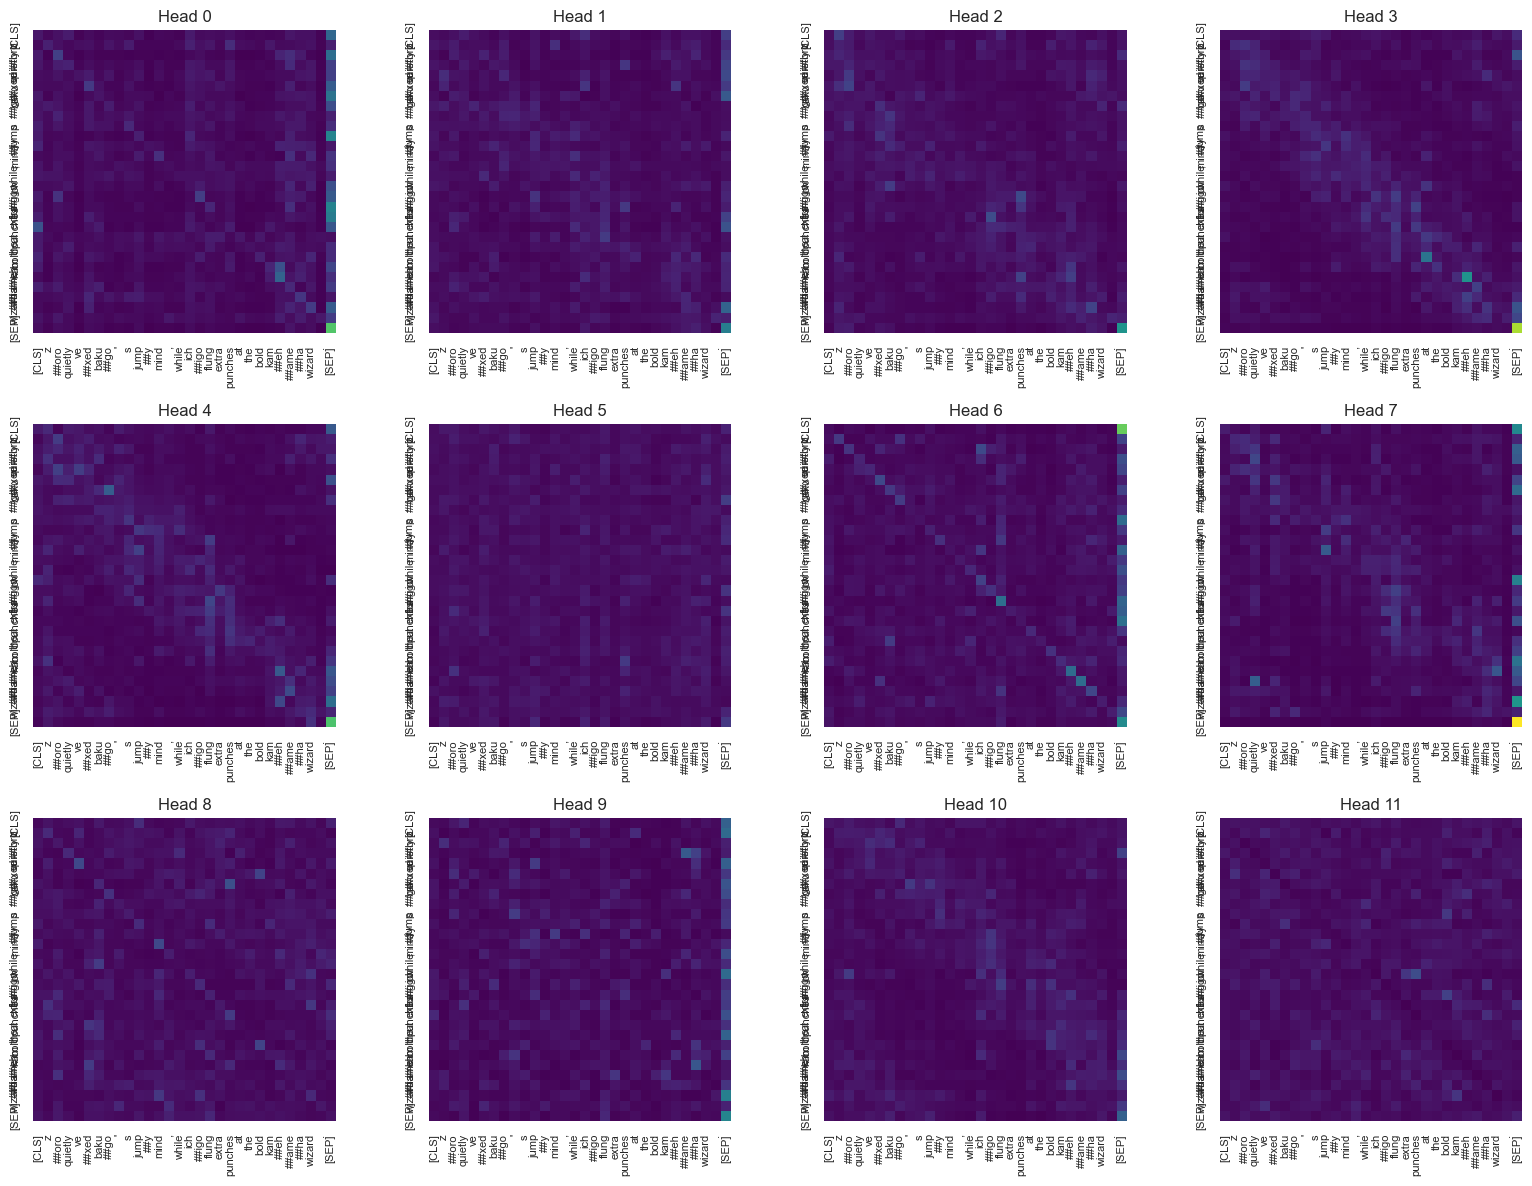

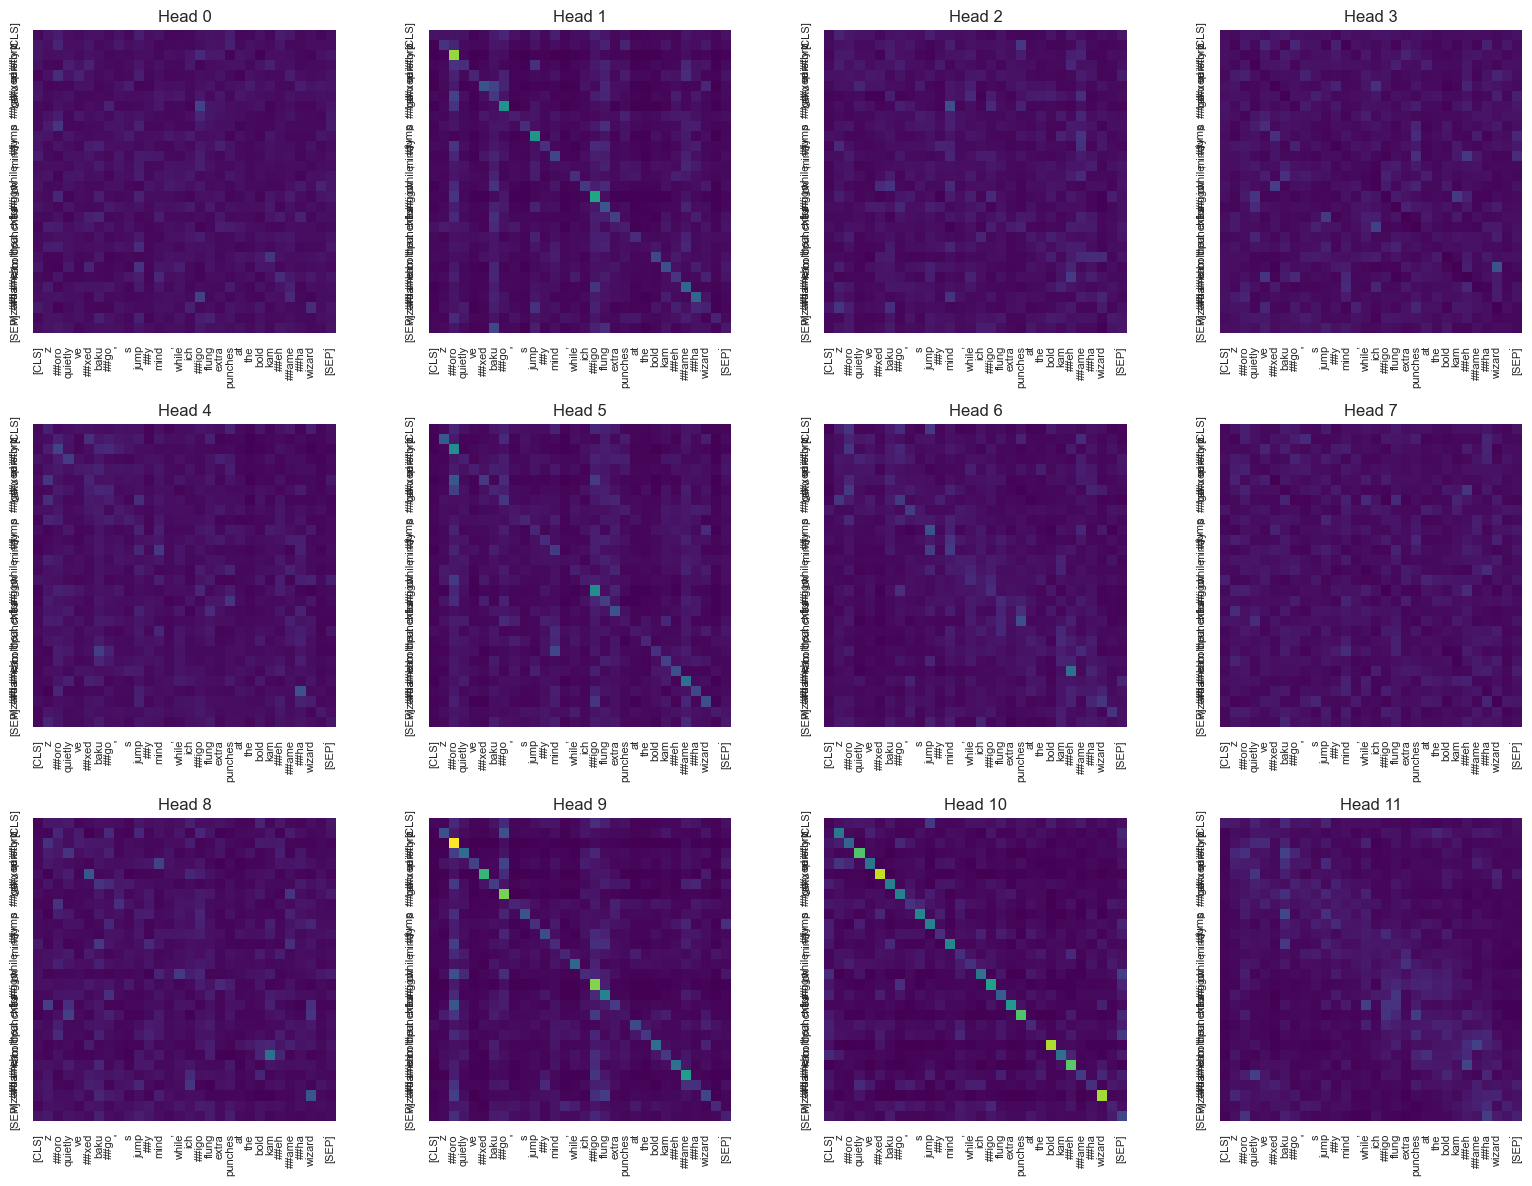

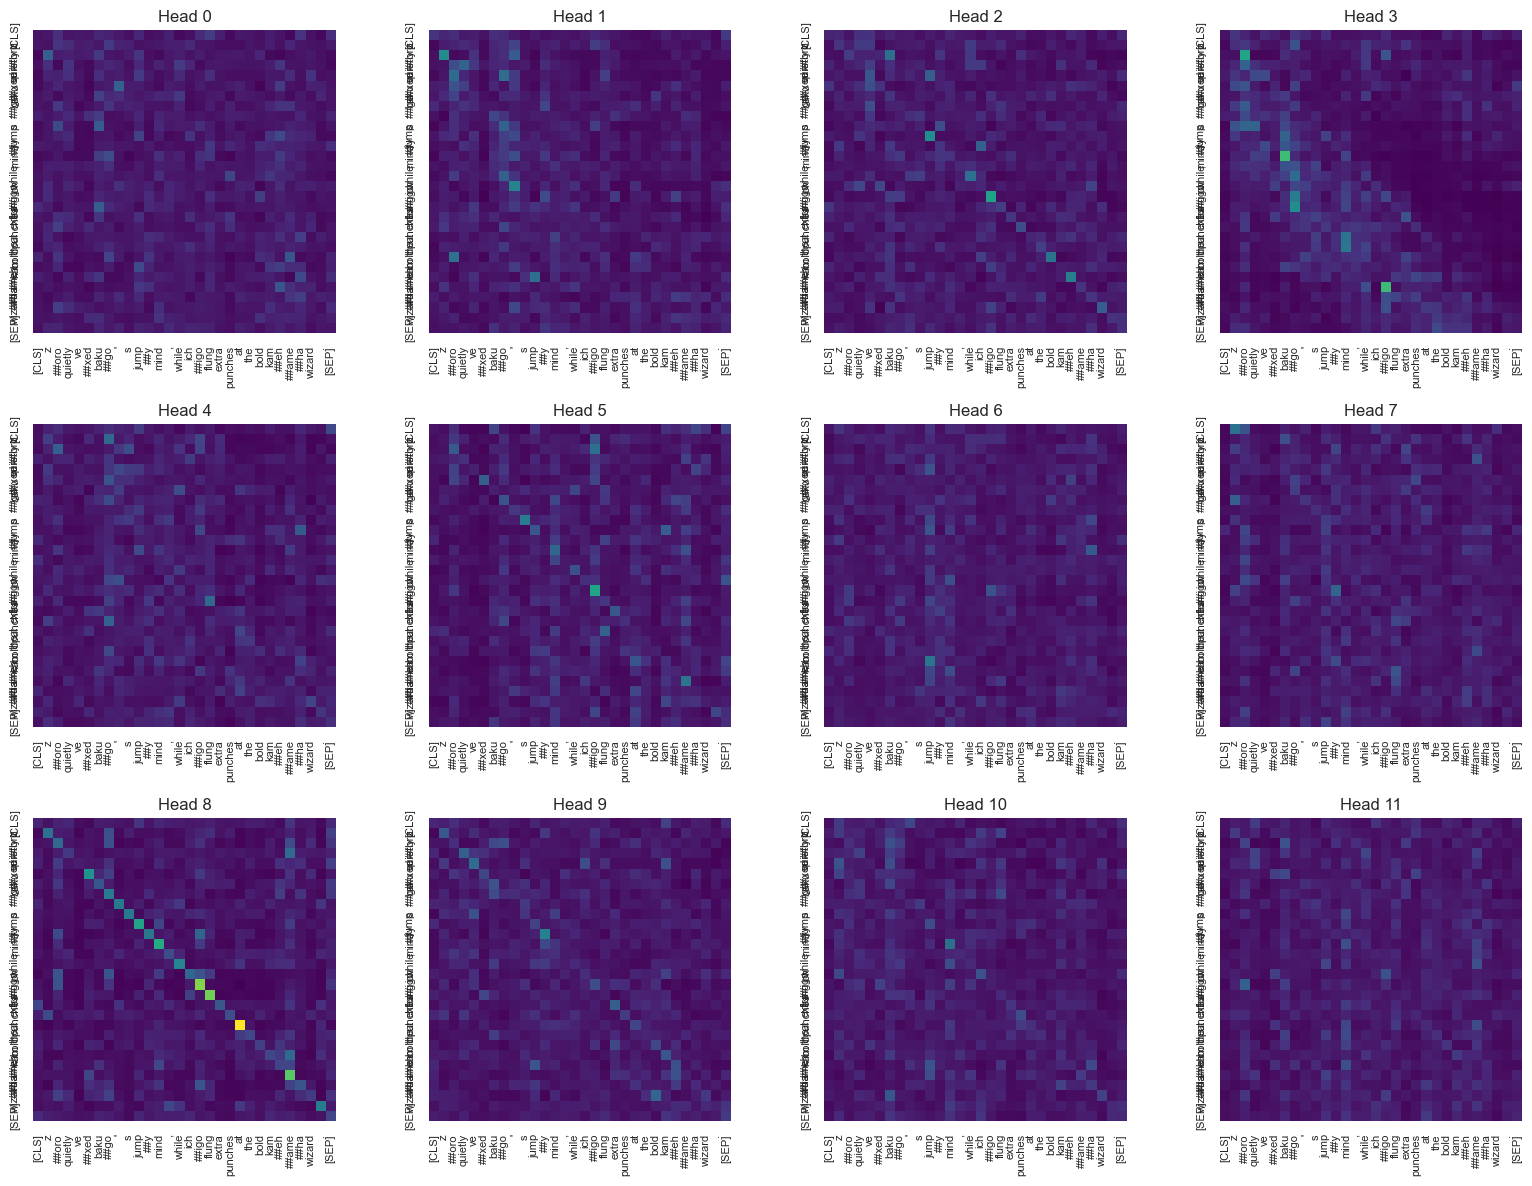

In [ ]:
# Visualize a different layer with layer_id.

for i in range(12):
    # Each layer has 12 heads - though that's NOT why we use 12 here.
    layer_id   = i # TODO: Visualize different layers!
    layer      = bert.encoder.layer[layer_id]

    bert_sa    = layer.attention.self
    bert_dout  = layer.attention.output.dense
    mha_L      = MultiHeadAttention(d_model=768, num_heads=12)

    with torch.no_grad():
        mha_L.W_q.weight.copy_(bert_sa.query.weight);  mha_L.W_q.bias.copy_(bert_sa.query.bias)
        mha_L.W_k.weight.copy_(bert_sa.key.weight);    mha_L.W_k.bias.copy_(bert_sa.key.bias)
        mha_L.W_v.weight.copy_(bert_sa.value.weight);  mha_L.W_v.bias.copy_(bert_sa.value.bias)
        mha_L.W_o.weight.copy_(bert_dout.weight);      mha_L.W_o.bias.copy_(bert_dout.bias)

    mha_L.eval()

    with torch.no_grad():
        x, mask, toks = embed_sentence(sentence)
        _, attn_L     = mha_L(x, mask)

    plot_heads(attn_L, toks, heads_per_row=4)